In [1]:
from Model.Energy import GaussianMixtureEnergy
from Model.Proposal import GaussianProposal
from Data import get_dataloader_from_data
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from Model.Trainer import SNLTrainer
from Model.Energy import MaxMinTruncation

/opt/miniconda3/envs/lime_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training data 

In [2]:
target_distribution_1 = torch.distributions.Normal(torch.tensor([1,1], dtype=torch.float32) , torch.tensor([2,1], dtype=torch.float32))
target_distribution_2 = torch.distributions.Normal(torch.tensor([-4,-4], dtype=torch.float32) , torch.tensor([2,1], dtype=torch.float32))
cluster_choice = torch.distributions.Categorical(torch.tensor([0.1,0.9]))

In [3]:
sample_choice = cluster_choice.sample((20000,1))
sample_target_cartesian = sample_choice * target_distribution_1.sample((20000,)) + (1-sample_choice) * target_distribution_2.sample((20000,))

# Select only the samples that are in the first quadrant
# sample_target_cartesian = sample_target_cartesian[sample_target_cartesian[:,0] > -1 ]
# sample_target_cartesian = sample_target_cartesian[:20000]




dataset_total = TensorDataset(sample_target_cartesian, )
data_train, data_val, data_test = torch.utils.data.random_split(dataset_total, [10000, 5000, 5000])
dataloader_train = DataLoader(data_train, batch_size=100, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=100, shuffle=False)

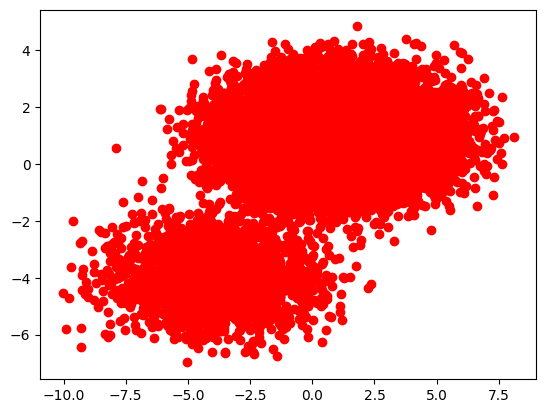

In [4]:


fig = plt.figure()
ax = fig.add_subplot(111)
# Add gaussian distribution as contours

# x = np.linspace(-20, 20, 100)
# y = np.linspace(-20, 20, 100)
# X, Y = np.meshgrid(x, y)
# Z = target_distribution.log_prob(torch.tensor([X,Y], dtype=torch.float32).permute(1,2,0)).sum(-1).exp().numpy()

# ax.contour(X, Y, Z, levels=10)


# Add points
ax.scatter(sample_target_cartesian[...,0], sample_target_cartesian[...,1], color='r')

# Proposal

In [5]:
proposal_distribution = GaussianProposal(torch.Size([2,]), torch.tensor([0,0], dtype=torch.float32), torch.tensor([10,10], dtype=torch.float32))

Init Standard Gaussian...


/var/folders/j8/dm7qjtj55w3f6yvlj6rd2vx40000gn/T/ipykernel_39282/2233292355.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/torch/csrc/utils/tensor_new.cpp:233.)
  input_grid = torch.tensor([X,Y], dtype=torch.float32).permute(1,2,0)


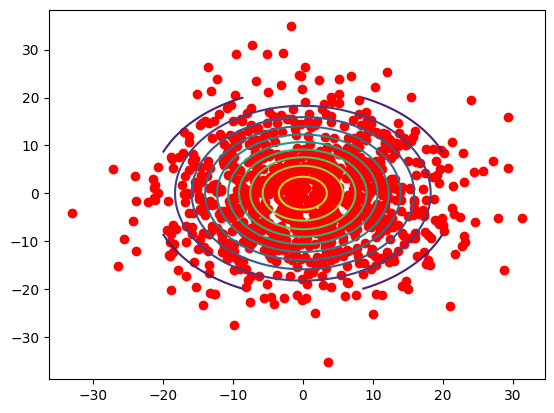

In [6]:
sample_proposal = proposal_distribution.sample(1000,)

fig = plt.figure()
ax = fig.add_subplot(111)
# Add gaussian distribution as contours

x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
input_grid = torch.tensor([X,Y], dtype=torch.float32).permute(1,2,0)
Z = proposal_distribution.log_prob(input_grid.flatten(0,1)).exp().numpy().reshape(X.shape)
ax.contour(X, Y, Z, levels=10)


# Add points
ax.scatter(sample_proposal[...,0], sample_proposal[...,1], color='r')

# Energy

In [7]:
energy = GaussianMixtureEnergy(dim=2, num_cluster=2, learn_mu=True, learn_sigma=True)
# energy.set_truncator(MaxMinTruncation(min = torch.tensor([-1,-20], dtype=torch.float32), max= torch.tensor([20,20], dtype=torch.float32)))

In [8]:
print(energy(x=sample_target_cartesian))
print(energy(x=sample_proposal))

tensor([0.8110, 1.1793, 1.1518,  ..., 1.9176, 0.3316, 1.1413],
       grad_fn=<NegBackward0>)
tensor([6.0233e+01, 3.9379e+01, 1.2142e+01, 1.7124e+01, 9.4317e+01, 4.1471e+00,
        4.0213e+00, 1.4544e+01, 9.8592e+00, 5.0259e+00, 4.3378e+00, 1.1843e+01,
        3.6296e+01, 6.9964e+01, 3.4714e+00, 5.8045e+00, 1.4208e+00, 5.9732e+00,
        6.6873e+01, 2.7000e+01, 3.0358e+01, 1.5077e+02, 4.9373e+01, 4.4222e+00,
        7.0624e+01, 3.9250e+01, 6.3981e+01, 3.1709e+01, 1.2048e+01, 5.5340e+01,
        7.4235e+00, 1.6405e+00, 2.1294e+01, 5.8211e+00, 1.1027e+01, 1.4735e+01,
        1.9846e+01, 3.3337e+01, 3.5488e+01, 4.6374e+00, 4.5587e+00, 1.5070e+01,
        5.7165e+01, 4.7031e+01, 1.8789e+01, 1.5484e+00, 9.5165e+01, 1.0971e+01,
        2.2495e+01, 3.3007e+01, 5.4935e+00, 1.1430e+02, 4.7683e+01, 8.2745e+01,
        2.8034e+00, 6.6946e+01, 9.7614e+00, 7.7892e+01, 3.3829e+01, 3.0416e+00,
        1.5997e+01, 3.2110e+00, 3.8178e+01, 4.1059e+00, 4.5746e+01, 1.7438e+01,
        1.1505e+00, 3.1354

/Users/hhjs/Documents/Projects/SNL_directional/Model/Energy/gaussian_mixture.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.log_softmax(self.logit_pi) - energy_per_cluster, dim=-1


# Trainer :


In [9]:
trainer = SNLTrainer(energy=energy, proposal=proposal_distribution, dataloader=dataloader_train, val_dataloader=dataloader_val , n_sample_train=1000, n_sample_test=1000, lr=0.01, )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hugosenetaire. Use `wandb login --relogin` to force relogin


/Users/hhjs/Documents/Projects/SNL_directional/Model/Energy/gaussian_mixture.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.log_softmax(self.logit_pi) - energy_per_cluster, dim=-1


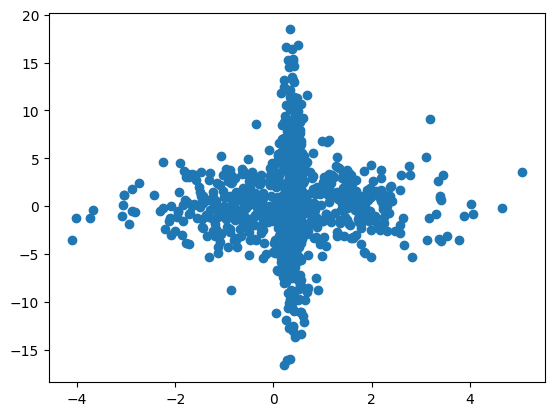

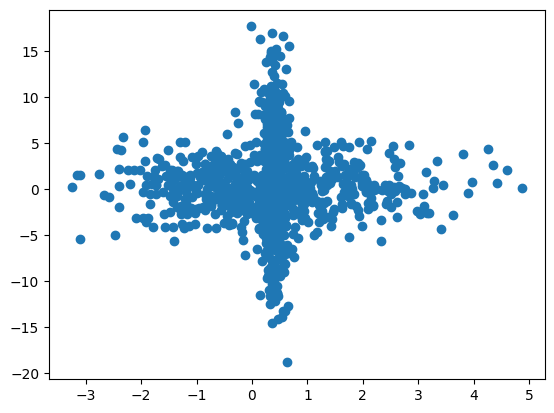

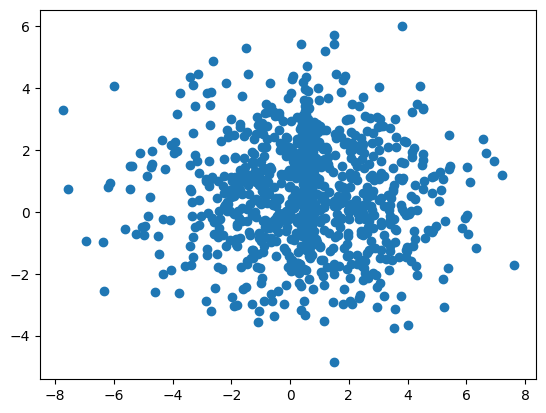

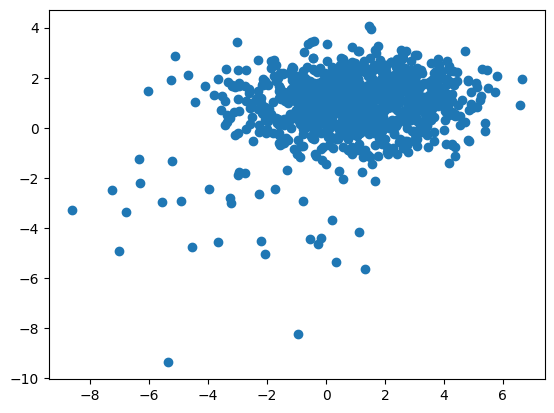

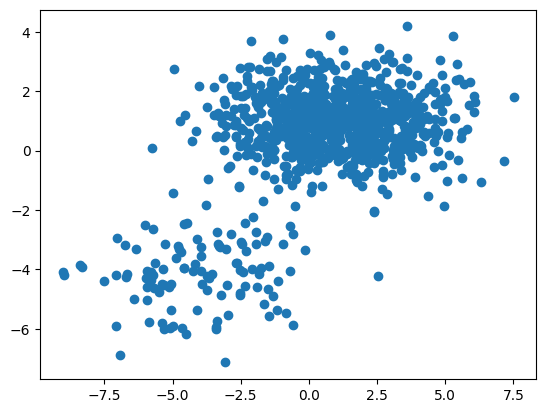

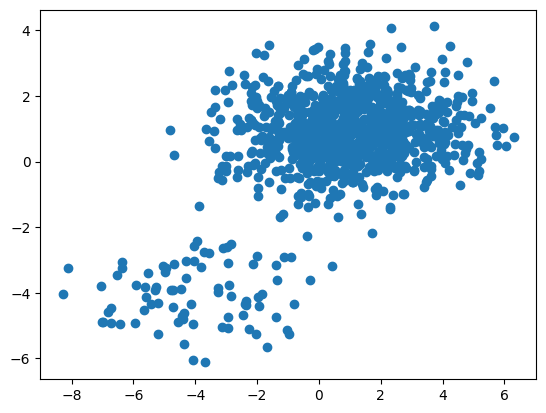

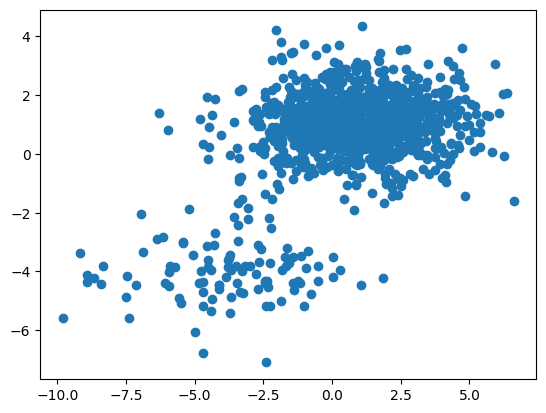

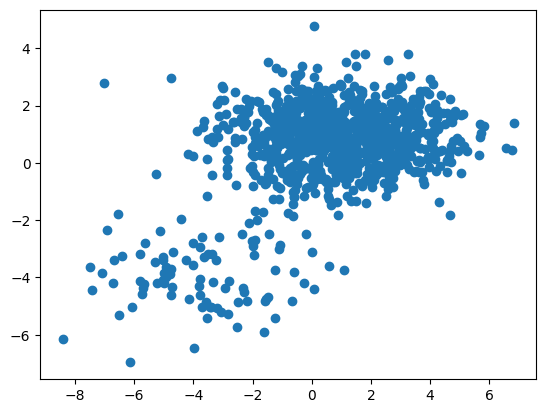

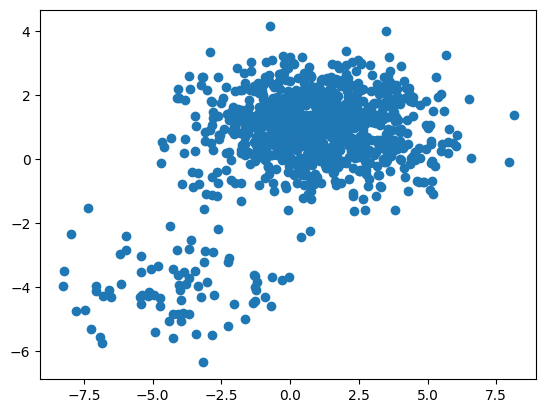

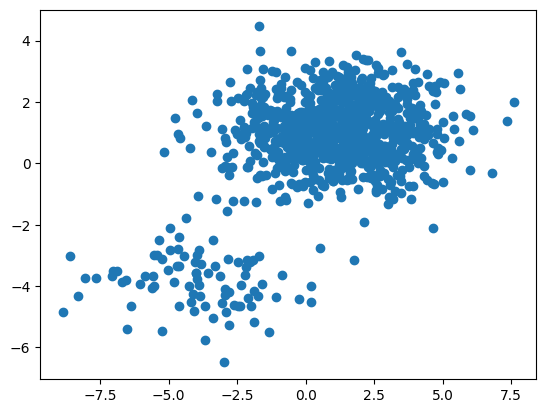

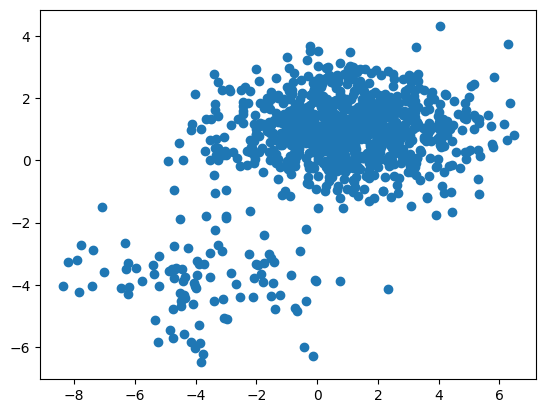

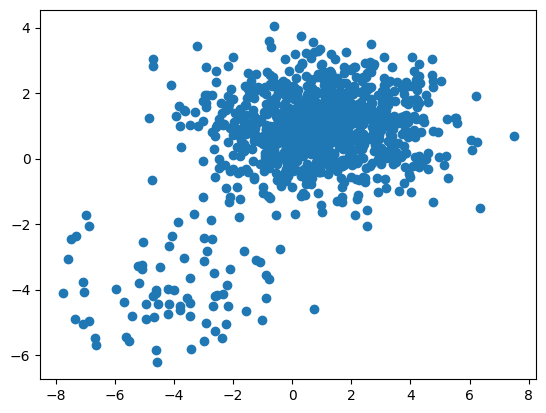

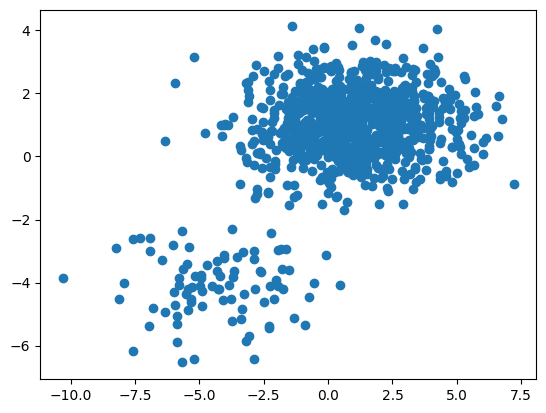

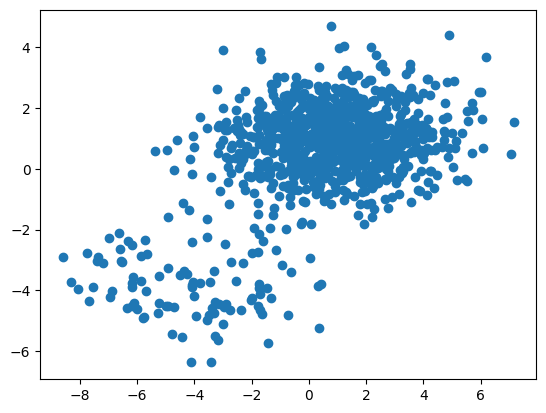

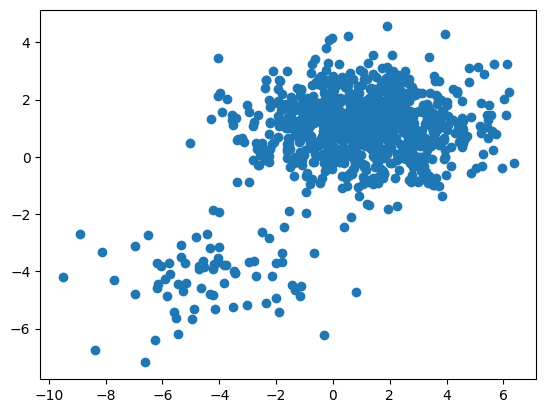

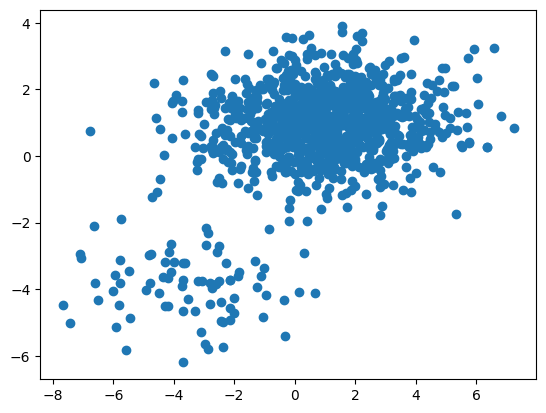

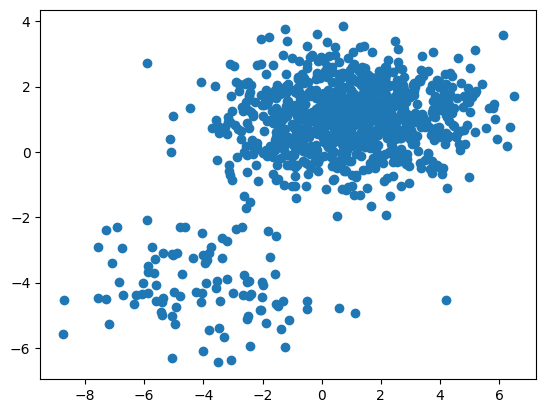

In [ ]:
trainer.train(n_iter=200_000, n_iter_pretrain=1000,)